# Data Source


1. Local Authority Districts (May 2023): [Office for National Statistics - Local Authority Districts (May 2023) UK BFC](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2023-uk-bfc-2/about) This file contains the digital vector boundaries for Local Authority Districts, in the United Kingdom, as at May 2023. 
1. Regions (December 2022): [Office for National Statistics - Regions (December 2022) EN BFC](https://geoportal.statistics.gov.uk/datasets/ons::regions-december-2022-en-bfc/about) This file contains the digital vector boundaries for Regions in England as at December 2022.
1. AADF Data by direction - major roads: [Department of Transport - Road traffic statistic](https://roadtraffic.dft.gov.uk/downloads)   Number of vehicles that travel past the count point on an average day of the year, by direction of travel.
1. Major Roads Database - shape file format (2021): [Department of Transport - Road traffic statistic](https://roadtraffic.dft.gov.uk/downloads) 	Shape file of the major road network 2021.
1. Traffic Network data: OSM

# Network Analysis

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon

<AxesSubplot:>

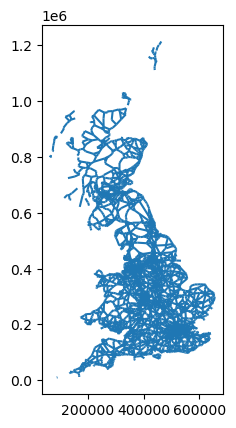

In [2]:
network = gpd.read_file('./road_network/shp/MRDB_2021.shp')
network.plot()

<AxesSubplot:>

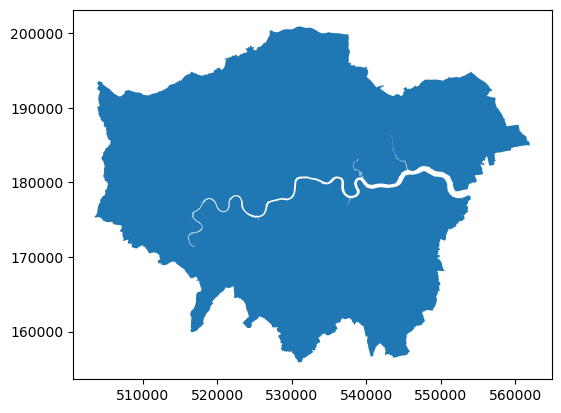

In [3]:
boundary = gpd.read_file('./road_network/shp/Regions_December_2022/RGN_DEC_2022_EN_BFC.shp')
london_boundary = boundary.query("RGN22NM=='London'")
london_boundary.to_file('./road_network/shp/london_boundary.shp')
london_boundary.plot()

In [4]:
london_boundary.head()

,RGN22CD,RGN22NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
6,E12000007,London,517515,178392,-0.30866,51.4923,acffd85b-3f72-4c43-809d-ebe797270444,"MULTIPOLYGON (((516122.679 172421.288, 516112...."


<AxesSubplot:>

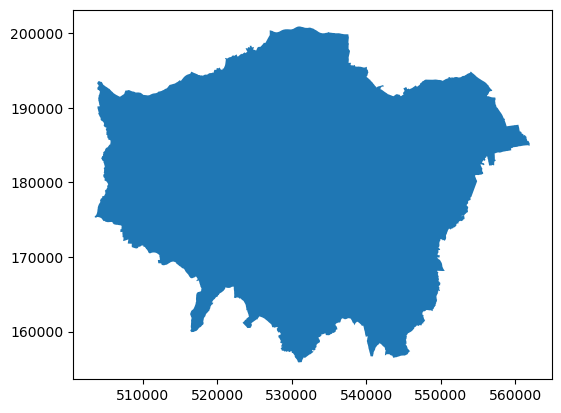

In [5]:
london_boundary = gpd.read_file('./road_network/shp/london_boundary_fixed.shp')
london_boundary.plot()

<AxesSubplot:>

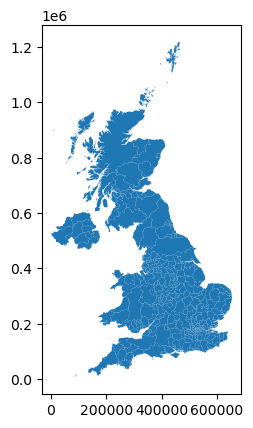

In [6]:
LAD_boundary = gpd.read_file('./road_network/shp/Local_Authority_Districts_May_2023/LAD_MAY_2023_UK_BFC.shp')
LAD_boundary.plot()

C:\Users\29425\AppData\Roaming\Python\Python39\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<AxesSubplot:>

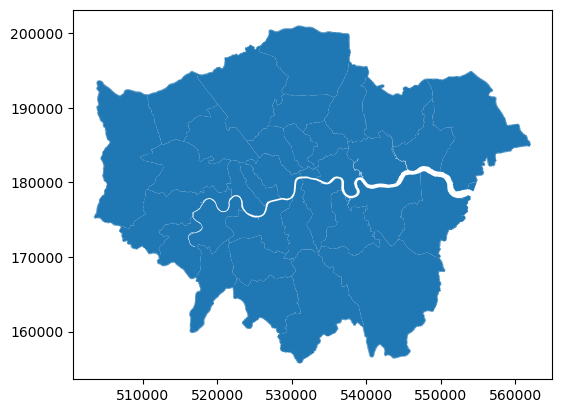

In [7]:
london_lad = LAD_boundary.intersection(london_boundary.unary_union)
london_lad.plot()

In [8]:
london_network = gpd.overlay(network, london_boundary, how='intersection').to_crs("EPSG:4326")
m = folium.Map(location=[london_network.geometry.centroid.y.mean(), london_network.geometry.centroid.x.mean()], zoom_start=12)
folium.GeoJson(london_boundary).add_to(m)
m

C:\Users\29425\AppData\Local\Temp\ipykernel_17500\2539384881.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[london_network.geometry.centroid.y.mean(), london_network.geometry.centroid.x.mean()], zoom_start=12)
C:\Users\29425\AppData\Local\Temp\ipykernel_17500\2539384881.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[london_network.geometry.centroid.y.mean(), london_network.geometry.centroid.x.mean()], zoom_start=12)


In [9]:
geometry = london_network['geometry'].explode().reset_index(drop=True)
# Creating an empty undirected graph
G = nx.Graph()


# Adding edges to the road network
for line in geometry:
    coords = list(line.coords)
    for u, v in zip(coords[:-1], coords[1:]):
        G.add_edge(u, v)


C:\Users\29425\AppData\Local\Temp\ipykernel_17500\198125845.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geometry = london_network['geometry'].explode().reset_index(drop=True)


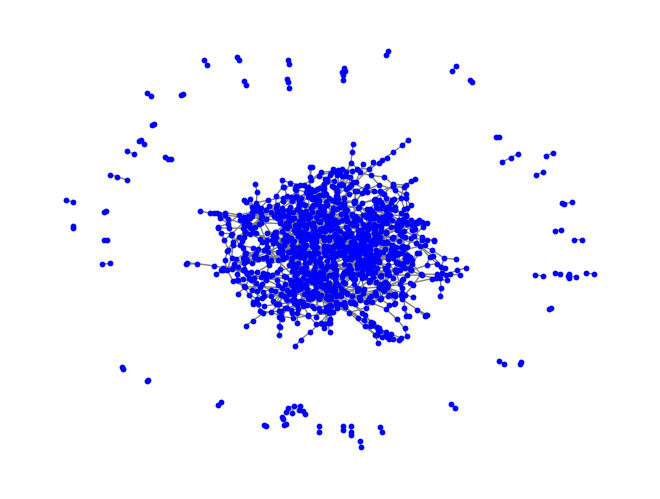

In [10]:
# Plotting Network Graphics
nx.draw(G, node_size=10, node_color='blue', edge_color='gray')

plt.show()

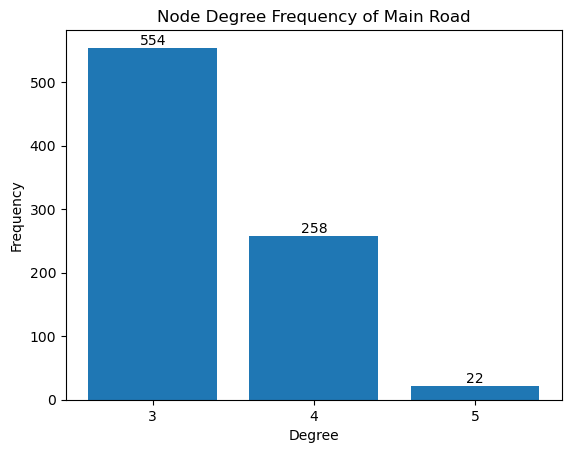

In [11]:
# Get the degree distribution of a node
degree_freq = nx.degree_histogram(G)

degrees = range(3,6,1)
plt.bar(degrees, degree_freq[3:6])
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Frequency of Main Road')
for i, freq in enumerate(degree_freq[3:6]):
    plt.text(i+3, freq, str(freq), ha='center', va='bottom')
plt.xticks(range(3, 6))
plt.show()

数据显示，London Region范围内的主要道路网络中三向路口的数量是最多的，四向路口的数量排名第二，还有剩余少量的五向和六向路口。
The data shows that the main road network within the London Region has the highest number of three-way junctions, with the second highest number of four-way junctions and a small number of remaining five-way and six-way junctions.

In [12]:
# Get the drive Network in London area from OSM
polygon = london_boundary.to_crs("EPSG:4326")
geometry = polygon['geometry']
polygon = Polygon(geometry.iloc[0].exterior)
graph = ox.graph_from_polygon(polygon, network_type="drive", simplify=True)

In [21]:
# 查看图的属性
print("Graph Attributes:")
print("Nodes:", graph.number_of_nodes())
print("Edges:", graph.number_of_edges())
print("Is Directed:", graph.is_directed())
print("Is MultiGraph:", graph.is_multigraph())
print("Is Weighted:", any("weight" in data for u, v, key, data in graph.edges(keys=True, data=True)))

# 如果图有节点属性，您可以像这样访问其中一个节点的属性：
if graph.number_of_nodes() > 0:
    node_id = next(iter(graph.nodes()))  # 获取第一个节点的ID
    node_attributes = graph.nodes[node_id]
    print("Attributes of Node", node_id, ":", node_attributes)

# 如果图有边属性，您可以像这样访问其中一条边的属性：
if graph.number_of_edges() > 0:
    edge = next(iter(graph.edges(keys=True, data=True)))  # 获取第一条边的信息
    edge_attributes = edge[3]  # 第四个元素是边的属性字典
    print("Attributes of Edge", edge[:2], ":", edge_attributes)

Graph Attributes:
Nodes: 128336
Edges: 299925
Is Directed: True
Is MultiGraph: True
Is Weighted: False
Attributes of Node 78112 : {'y': 51.526976, 'x': -0.1457924, 'street_count': 3}
Attributes of Edge (78112, 25508583) : {'osmid': 129375498, 'name': 'Outer Circle', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'reversed': False, 'length': 19.391}


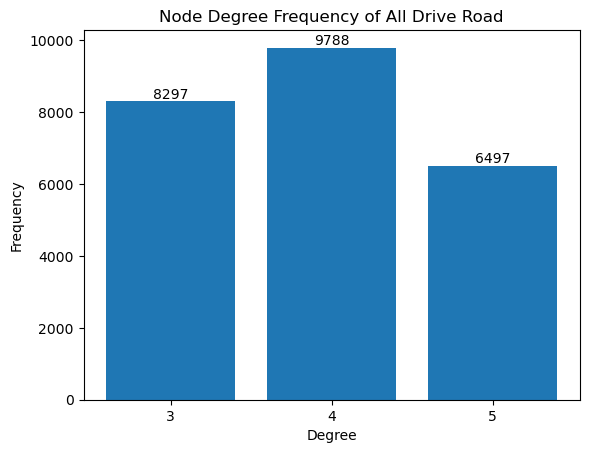

In [13]:
# Get the degree distribution of a node
degree_freq = nx.degree_histogram(graph)

degrees = range(3,6,1)
plt.bar(degrees, degree_freq[3:6])
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Frequency of All Drive Road')
for i, freq in enumerate(degree_freq[3:6]):
    plt.text(i+3, freq, str(freq), ha='center', va='bottom')
plt.xticks(range(3, 6))
plt.show()

# Traffic Flow

In [14]:
csv = pd.read_csv("./road_network/dft_traffic_counts_aadf_by_direction.csv") # E12000007
csv.info()
csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965328 entries, 0 to 965327
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Count_point_id                965328 non-null  int64  
 1   Year                          965328 non-null  int64  
 2   Region_id                     965328 non-null  int64  
 3   Region_name                   965328 non-null  object 
 4   Region_ons_code               965328 non-null  object 
 5   Local_authority_id            965328 non-null  int64  
 6   Local_authority_name          965328 non-null  object 
 7   Local_authority_code          965328 non-null  object 
 8   Road_name                     965328 non-null  object 
 9   Road_category                 965328 non-null  object 
 10  Road_type                     965328 non-null  object 
 11  Start_junction_road_name      737095 non-null  object 
 12  End_junction_road_name        737112 non-nul

,Count_point_id,Year,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,Local_authority_code,Road_name,Road_category,...,Buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles
0,57093,2010,1,South West,E12000009,139,Cornwall excluding Isles of Scilly,E06000052,A3058,PA,...,64,448,36,3,4,2,1,1,47,3762
1,57094,2010,8,Yorkshire and the Humber,E12000003,130,North Lincolnshire,E06000013,A160,TA,...,14,963,202,87,149,165,798,730,2131,5659
2,57094,2010,8,Yorkshire and the Humber,E12000003,130,North Lincolnshire,E06000013,A160,TA,...,14,873,184,93,140,65,403,1427,2312,6045
3,57095,2010,8,Yorkshire and the Humber,E12000003,169,"Kingston upon Hull, City of",E06000010,A1165,PA,...,19,1499,168,54,36,21,32,74,385,7041
4,57095,2010,8,Yorkshire and the Humber,E12000003,169,"Kingston upon Hull, City of",E06000010,A1165,PA,...,24,1454,163,44,36,14,31,73,361,6229


In [15]:
london_road = csv.query("Region_ons_code=='E12000007' & Year==2021")
london_road.info()
london_road.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3806 entries, 482277 to 524173
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Count_point_id                3806 non-null   int64  
 1   Year                          3806 non-null   int64  
 2   Region_id                     3806 non-null   int64  
 3   Region_name                   3806 non-null   object 
 4   Region_ons_code               3806 non-null   object 
 5   Local_authority_id            3806 non-null   int64  
 6   Local_authority_name          3806 non-null   object 
 7   Local_authority_code          3806 non-null   object 
 8   Road_name                     3806 non-null   object 
 9   Road_category                 3806 non-null   object 
 10  Road_type                     3806 non-null   object 
 11  Start_junction_road_name      3382 non-null   object 
 12  End_junction_road_name        3382 non-null   object 
 13  E

,Count_point_id,Year,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,Local_authority_code,Road_name,Road_category,...,Buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles
482277,6000,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,145,5521,1430,112,208,64,104,421,2339,22518
482278,6000,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,174,4360,1062,92,279,132,130,516,2211,21947
482279,6001,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,26,5434,786,130,189,49,132,785,2072,31779
482280,6001,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,28,6576,829,129,200,48,110,492,1808,33197
482295,6013,2021,6,London,E12000007,66,Hillingdon,E09000017,M4,TM,...,250,7461,1516,180,573,75,154,803,3301,53935


In [16]:
london_road["All_vehicles"] = london_road["All_HGVs"] + london_road["All_motor_vehicles"]
london_road.info()
london_road.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3806 entries, 482277 to 524173
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Count_point_id                3806 non-null   int64  
 1   Year                          3806 non-null   int64  
 2   Region_id                     3806 non-null   int64  
 3   Region_name                   3806 non-null   object 
 4   Region_ons_code               3806 non-null   object 
 5   Local_authority_id            3806 non-null   int64  
 6   Local_authority_name          3806 non-null   object 
 7   Local_authority_code          3806 non-null   object 
 8   Road_name                     3806 non-null   object 
 9   Road_category                 3806 non-null   object 
 10  Road_type                     3806 non-null   object 
 11  Start_junction_road_name      3382 non-null   object 
 12  End_junction_road_name        3382 non-null   object 
 13  E

C:\Users\29425\AppData\Local\Temp\ipykernel_17500\2168367199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_road["All_vehicles"] = london_road["All_HGVs"] + london_road["All_motor_vehicles"]


,Count_point_id,Year,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,Local_authority_code,Road_name,Road_category,...,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles,All_vehicles
482277,6000,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,5521,1430,112,208,64,104,421,2339,22518,24857
482278,6000,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,4360,1062,92,279,132,130,516,2211,21947,24158
482279,6001,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,5434,786,130,189,49,132,785,2072,31779,33851
482280,6001,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,6576,829,129,200,48,110,492,1808,33197,35005
482295,6013,2021,6,London,E12000007,66,Hillingdon,E09000017,M4,TM,...,7461,1516,180,573,75,154,803,3301,53935,57236


In [17]:
# linear normalized the vehicles
london_road["all_vehicles_normalized"] = (london_road["All_vehicles"] - london_road["All_vehicles"].min()) / (london_road["All_vehicles"].max() - london_road["All_vehicles"].min())
london_road.info()
london_road.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3806 entries, 482277 to 524173
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Count_point_id                3806 non-null   int64  
 1   Year                          3806 non-null   int64  
 2   Region_id                     3806 non-null   int64  
 3   Region_name                   3806 non-null   object 
 4   Region_ons_code               3806 non-null   object 
 5   Local_authority_id            3806 non-null   int64  
 6   Local_authority_name          3806 non-null   object 
 7   Local_authority_code          3806 non-null   object 
 8   Road_name                     3806 non-null   object 
 9   Road_category                 3806 non-null   object 
 10  Road_type                     3806 non-null   object 
 11  Start_junction_road_name      3382 non-null   object 
 12  End_junction_road_name        3382 non-null   object 
 13  E

C:\Users\29425\AppData\Local\Temp\ipykernel_17500\1360467440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_road["all_vehicles_normalized"] = (london_road["All_vehicles"] - london_road["All_vehicles"].min()) / (london_road["All_vehicles"].max() - london_road["All_vehicles"].min())


,Count_point_id,Year,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,Local_authority_code,Road_name,Road_category,...,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles,All_vehicles,all_vehicles_normalized
482277,6000,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,1430,112,208,64,104,421,2339,22518,24857,0.243491
482278,6000,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,1062,92,279,132,130,516,2211,21947,24158,0.236644
482279,6001,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,786,130,189,49,132,785,2072,31779,33851,0.331593
482280,6001,2021,6,London,E12000007,57,Barnet,E09000003,M1,TM,...,829,129,200,48,110,492,1808,33197,35005,0.342897
482295,6013,2021,6,London,E12000007,66,Hillingdon,E09000017,M4,TM,...,1516,180,573,75,154,803,3301,53935,57236,0.560665


The Sample intersection located at the south-east of Hyde park   
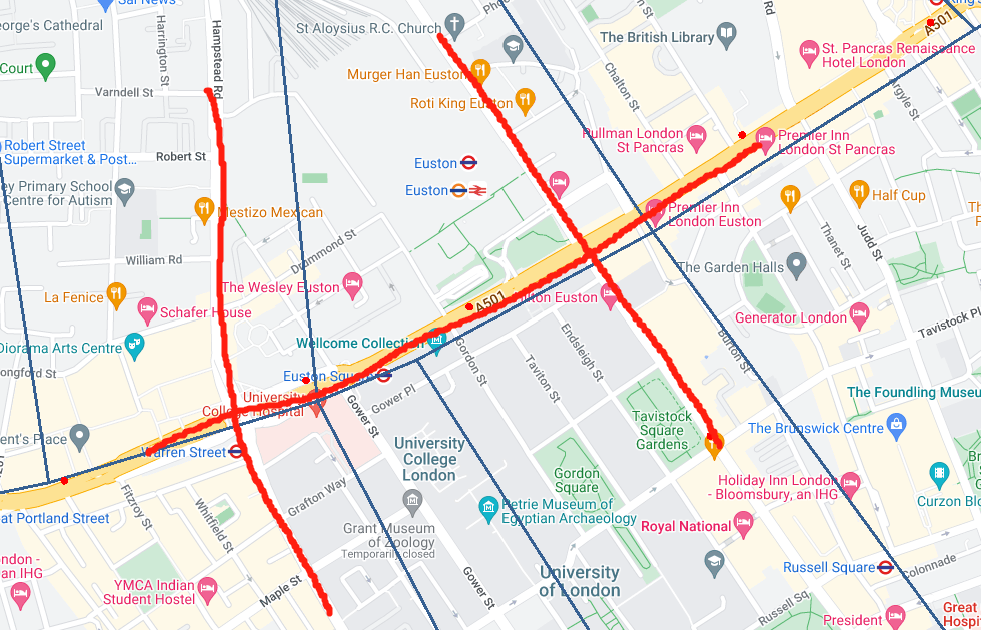

Road count point id and name is:    

|Position|Count point id|Name|
|--|--|--|
|North-S1|7044|A400|
|South-S1|37101|A400|
|East-S1|76054|A501|
|West-S1|47245|A501|   
|North-S2|56990|A4200|
|South-S2|90230|A4200|
|East-S2|56815|A501|
|West-S2|17169|A501|  



In [18]:
sample_intersection = london_road[london_road['Count_point_id'].isin([7044, 37101, 76054, 47245, 56990, 90230, 56815, 17169])]
sample_intersection["direction"] = sample_intersection["direction_of_travel"]
# sample_intersection.info()
sample_intersection.head(20)

C:\Users\29425\AppData\Local\Temp\ipykernel_17500\4138503609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_intersection["direction"] = sample_intersection["direction_of_travel"]


,Count_point_id,Year,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,Local_authority_code,Road_name,Road_category,...,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles,All_vehicles,all_vehicles_normalized,direction
483369,7044,2021,6,London,E12000007,145,Camden,E09000007,A400,PA,...,32,66,16,6,15,283,6611,6894,0.067531,N
483370,7044,2021,6,London,E12000007,145,Camden,E09000007,A400,PA,...,28,68,11,6,15,261,9839,10100,0.098936,S
487071,17169,2021,6,London,E12000007,145,Camden,E09000007,A501,PA,...,60,89,22,40,30,709,29734,30443,0.298209,E
487072,17169,2021,6,London,E12000007,145,Camden,E09000007,A501,PA,...,51,70,26,32,16,610,23737,24347,0.238495,W
493907,37101,2021,6,London,E12000007,145,Camden,E09000007,A400,PA,...,59,76,17,10,4,624,10488,11112,0.108849,N
497499,47245,2021,6,London,E12000007,145,Camden,E09000007,A501,PA,...,97,306,26,10,69,1463,31712,33175,0.324971,E
497500,47245,2021,6,London,E12000007,145,Camden,E09000007,A501,PA,...,123,311,16,17,54,1512,30271,31783,0.311336,W
500705,56815,2021,6,London,E12000007,145,Camden,E09000007,A501,PA,...,56,226,29,16,59,938,21550,22488,0.220285,E
500706,56815,2021,6,London,E12000007,145,Camden,E09000007,A501,PA,...,56,200,16,8,46,883,21960,22843,0.223762,W
500951,56990,2021,6,London,E12000007,145,Camden,E09000007,A4200,PA,...,21,21,1,2,2,142,5919,6061,0.059372,N


Focusing only on the in-flow traffic without considering the turning of vehicles, the final obtained flow is:

|Position|Count point id|Name|Direction|Flow|Simple flow|
|--|--|--|--|--|--|
|North-S1|7044|A400|S|0.098936|0.10|
|South-S1|37101|A400|N|0.108849|0.11|
|West-S1|47245|A501|E|0.324971|0.32|
|--|--|--|--|--|--|   
|North-S2|56990|A4200|N|0.059372|0.06|
|South-S2|90230|A4200|N|0.100151|0.10|
|East-S2|56815|A501|E|0.220285|0.22|
|West-S2|17169|A501|W|0.238495|0.24|   
|North-S2|56990|A4200|S|0.033129|0.03|
|South-S2|90230|A4200|S|0.106459|0.11|
|East-S2|56815|A501|W|0.223762|0.22|
|West-S2|17169|A501|E|0.298209|0.30|   